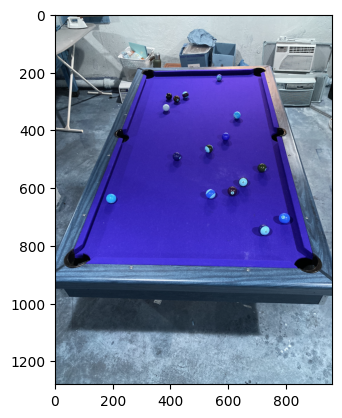

In [128]:
import cv2
from sympy import Point, Ellipse
import matplotlib.pyplot as plt
import numpy as np
x1='images/all_balls/1280x1280/1.png'
grayscale = cv2.imread(x1, 0)
image1 = cv2.imread(x1,1)

plt.imshow(image1)
plt.show()


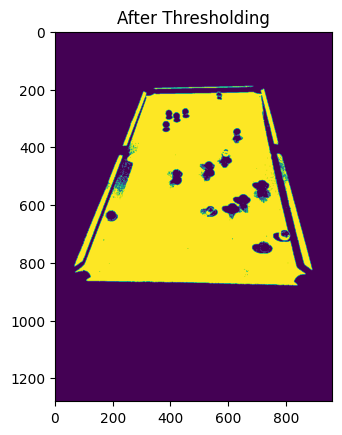

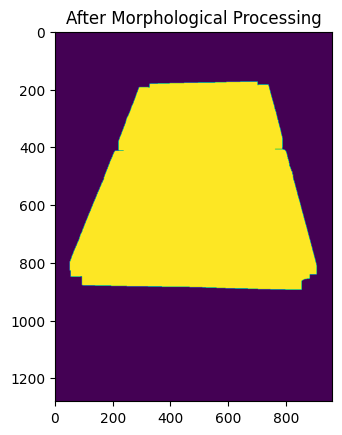

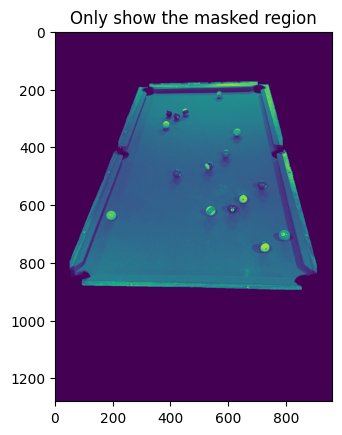

In [129]:
# order is blue, green, red
lower_blue = np.array([0,0,150])
upper_blue = np.array([150,100,255])
# Threshold the HSV image to get only blue colors
mask = cv2.inRange(image1, lower_blue, upper_blue)
plt.title('After Thresholding')
plt.imshow(mask)
plt.show()
erosion = mask
kernel = np.ones((7,7),np.uint8)
dilation = cv2.dilate(erosion, kernel, iterations = 5)

plt.title('After Morphological Processing')
plt.imshow(dilation)
plt.show()

res = cv2.bitwise_and(grayscale, dilation)
plt.title('Only show the masked region')
plt.imshow(res)
plt.show()

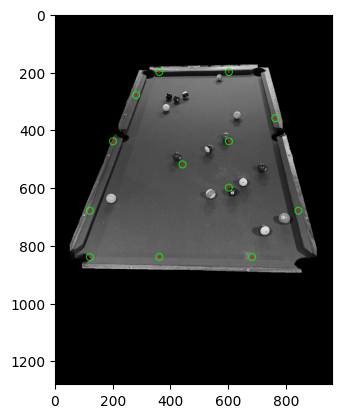

In [126]:
cimg = cv2.cvtColor(res,cv2.COLOR_GRAY2BGR)
circles = cv2.HoughCircles(res,cv2.HOUGH_GRADIENT,dp=80, minRadius=0, maxRadius=40, minDist=1)
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

plt.imshow(cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB))

